# Project for Hardware  & Software for big Data (module A)
*(author: Daniele Petrillo P37000102)*

The **aim** of the project is to use **Community Detection** algorithms to create **clusters** of stocks sampled from the **S&P500** index.

The notebook is divided into four parts:

  1. **Preparation** of the dataset using **Pyspark**
  2. Simulation of the **streaming** of the dataset through **Kafka**
  3. **EDA** using **Pandas**
  4. **Community Detection** through **NetworkX**

## Part 1: Preparation of the data

In [ ]:
# mount Google Drive
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# run Spark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#!wget http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf /content/drive/MyDrive/HWSWmoduleA/spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [ ]:
# set environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [ ]:
# import and initialize findspark
import findspark
findspark.init()

In [ ]:
# start a pyspark session
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)
spark

In [ ]:
# load the dataset in pyspark
df_pyspark = spark.read.csv("/content/drive/MyDrive/HWSWmoduleA/sp500_stocks.csv", header=True)
df_pyspark.show(5)

+----------+------+------------------+-----------------+-----------------+-----------------+-----------------+-------+
|      Date|Symbol|         Adj Close|            Close|             High|              Low|             Open| Volume|
+----------+------+------------------+-----------------+-----------------+-----------------+-----------------+-------+
|2010-01-04|   MMM|59.318885803222656| 83.0199966430664|83.44999694824219|82.66999816894531|83.08999633789062|3043700|
|2010-01-05|   MMM| 58.94734191894531|             82.5| 83.2300033569336|81.69999694824219|82.80000305175781|2847000|
|2010-01-06|   MMM|59.783294677734375|83.66999816894531| 84.5999984741211|83.51000213623047|83.87999725341797|5268500|
|2010-01-07|   MMM|59.826175689697266| 83.7300033569336|83.76000213623047|82.12000274658203|83.31999969482422|4470100|
|2010-01-08|   MMM| 60.24774932861328|84.31999969482422|84.31999969482422|83.30000305175781|83.69000244140625|3405800|
+----------+------+------------------+----------

In [ ]:
# let's look at the types of the columns
df_pyspark.dtypes

[('Date', 'string'),
 ('Symbol', 'string'),
 ('Adj Close', 'string'),
 ('Close', 'string'),
 ('High', 'string'),
 ('Low', 'string'),
 ('Open', 'string'),
 ('Volume', 'string')]

In [ ]:
from pyspark.sql.functions import to_date
from pyspark.sql.types import DateType
from pyspark.sql.functions import col

# let's change the types of the numeric columns from string to the actual type
numeric_cols = ["Adj Close", "Close", "High", "Low", "Open", "Volume"]
for col_name in numeric_cols:
    df_pyspark = df_pyspark.withColumn(col_name, col(col_name).cast('float'))

In [ ]:
# let's look at the types of the columns again to see if they changed
df_pyspark.dtypes

[('Date', 'string'),
 ('Symbol', 'string'),
 ('Adj Close', 'float'),
 ('Close', 'float'),
 ('High', 'float'),
 ('Low', 'float'),
 ('Open', 'float'),
 ('Volume', 'float')]

In [ ]:
# some stats on the dataset
df_pyspark.summary().show()

+-------+----------+-------+------------------+------------------+------------------+------------------+------------------+-------------------+
|summary|      Date| Symbol|         Adj Close|             Close|              High|               Low|              Open|             Volume|
+-------+----------+-------+------------------+------------------+------------------+------------------+------------------+-------------------+
|  count|   1794201|1794201|           1714288|           1714288|           1714288|           1714288|           1714288|            1714288|
|   mean|      null|   null| 95.72522509561246|102.64200552379694|103.76725430194739|101.45577584877337|102.61854800683831|  5892795.611819601|
| stddev|      null|   null|195.50987514184135|195.40076270811915|197.68927856317288|193.00689930671587|195.30100508920327|1.984405429894815E7|
|    min|2010-01-04|      A|               0.7|               0.7|              0.71|              0.65|               0.7|             

In [ ]:
# some additional information about the stocks
nrows = df_pyspark.count()
nstocks = df_pyspark.select("Symbol").distinct()
print(f"There are a total of {nrows} rows and {nstocks.count()} different stocks")

from pyspark.sql.functions import min, max
min_date, max_date = df_pyspark.select(min("Date"), max("Date")).first()
print(f"The stock exchange starts from {min_date} and ends on {max_date}")

There are a total of 1794201 rows and 503 different stocks
The stock exchange starts from 2010-01-04 and ends on 2024-03-06


In [ ]:
# for computational time reasons, we filter the data to only cover a certain period of time
# we will only keep the period of time between 2023-05-02 and 2023-07-31
import datetime
from datetime import timedelta
import pandas

start_date = datetime.date(2023,5,2)
end_date = datetime.date(2023,7,31)
delta = end_date - start_date   # returns timedelta
daterange = []
for i in range(delta.days + 1):
    day = start_date + timedelta(days=i)
    daterange.append(day.strftime("%Y-%m-%d"))

In [ ]:
df_pyspark = df_pyspark.filter(df_pyspark.Date.isin(daterange))
df_pyspark.show(5)

+----------+------+---------+------+------+------+------+---------+
|      Date|Symbol|Adj Close| Close|  High|   Low|  Open|   Volume|
+----------+------+---------+------+------+------+------+---------+
|2023-05-02|   MMM|   102.98|102.98| 105.7|102.66|105.51|3012000.0|
|2023-05-03|   MMM|   102.83|102.83| 104.6|102.67| 103.5|2056100.0|
|2023-05-04|   MMM|   101.84|101.84|102.98|100.76|102.55|2963200.0|
|2023-05-05|   MMM|   103.35|103.35|103.48|102.05| 102.8|1943100.0|
|2023-05-08|   MMM|   102.34|102.34|103.93|101.65|103.56|2094000.0|
+----------+------+---------+------+------+------+------+---------+
only showing top 5 rows



In [ ]:
# sample 100 unique stocks from the filtered dataframe
sampled_df = df_pyspark.select("Symbol").distinct().sample(fraction=1.0).limit(100)

In [ ]:
# make sure there are oly 100 unique stocks left
sampled_df.select("Symbol").distinct().count()

100

In [ ]:
# join with the original data to filter the stocks
joined_df = sampled_df.join(df_pyspark, on="symbol", how="inner")

In [ ]:
# the number of rows should now be 6200 = 62 days * 100 stocks
joined_df.count()

6200

In [ ]:
# take a look at the new dataset
joined_df.show(10)

+------+----------+---------+------+------+------+------+---------+
|Symbol|      Date|Adj Close| Close|  High|   Low|  Open|   Volume|
+------+----------+---------+------+------+------+------+---------+
|   MMM|2023-05-02|   102.98|102.98| 105.7|102.66|105.51|3012000.0|
|   MMM|2023-05-03|   102.83|102.83| 104.6|102.67| 103.5|2056100.0|
|   MMM|2023-05-04|   101.84|101.84|102.98|100.76|102.55|2963200.0|
|   MMM|2023-05-05|   103.35|103.35|103.48|102.05| 102.8|1943100.0|
|   MMM|2023-05-08|   102.34|102.34|103.93|101.65|103.56|2094000.0|
|   MMM|2023-05-09|    100.8| 100.8|101.75| 100.4|101.47|3121400.0|
|   MMM|2023-05-10|    100.9| 100.9| 101.7|  99.6|101.39|2744100.0|
|   MMM|2023-05-11|   100.78|100.78| 101.0|  99.8| 100.5|2774000.0|
|   MMM|2023-05-12|   100.27|100.27|101.27| 99.27|101.21|2455300.0|
|   MMM|2023-05-15|   100.49|100.49|100.83| 99.27|100.07|2407000.0|
+------+----------+---------+------+------+------+------+---------+
only showing top 10 rows



In [ ]:
# finally, we turn the dataframe into a csv file to transfer it through Kafka
joined_df.toPandas().to_csv("/content/drive/MyDrive/HWSWmoduleA/sp100_stocks_62days.csv")

## Part 2: Simulation of a Kafka streaming

In [ ]:
# install the required libraries
!pip install kafka-python
!pip install confluent-kafka

In [ ]:
# setup Kafka and Zookeeper instances
!tar -xzf /content/drive/MyDrive/HWSWmoduleA/kafka_2.13-3.3.1.tgz

In [ ]:
# use the default configurations (provided by Apache Kafka) for spinning up the instances
!./kafka_2.13-3.3.1/bin/zookeeper-server-start.sh -daemon ./kafka_2.13-3.3.1/config/zookeeper.properties
!./kafka_2.13-3.3.1/bin/kafka-server-start.sh -daemon ./kafka_2.13-3.3.1/config/server.properties
!echo "Waiting for 10 secs until kafka and zookeeper services are up and running"
!sleep 10

Waiting for 10 secs until kafka and zookeeper services are up and running


In [ ]:
# create the Kafka topic
!./kafka_2.13-3.3.1/bin/kafka-topics.sh --create --bootstrap-server localhost:9092 --replication-factor 1 --partitions 1 --topic SMP500

Created topic SMP500.


In [ ]:
# setup the producer and consumer
import requests
from confluent_kafka import Producer
from confluent_kafka import Consumer, KafkaException

kafka_bootstrap_servers = "localhost:9092"
kafka_topic = "SMP500"

# Kafka producer and consumer configuration
producer_config = {
    "bootstrap.servers": kafka_bootstrap_servers,
}
consumer_config = {
    "bootstrap.servers": kafka_bootstrap_servers,
    "group.id": "your_consumer_group_id",
    "auto.offset.reset": "earliest",
}

# create instances
producer = Producer(producer_config)
consumer = Consumer(consumer_config)

# consumer subscribes to the SMP500 topic
consumer.subscribe([kafka_topic])

In [ ]:
# read the dataset from the drive
import pandas as pd
dataset = pd.read_csv("/content/drive/MyDrive/HWSWmoduleA/sp100_stocks_62days.csv", index_col=0).to_json(orient="records")

# producer posts the message to the topic
producer.produce(kafka_topic, value=dataset)

In [ ]:
# consumer reads the message event
event = consumer.poll(1)
event_value = event.value()
consumer.close()

In [ ]:
# consumer reconstructs the dataset from the value
import json
decoded_dataset = json.loads(event_value.decode("utf-8"))
df = pd.DataFrame(decoded_dataset)
df

,Symbol,Date,Adj Close,Close,High,Low,Open,Volume
0,MMM,2023-05-02,102.98000,102.98,105.70,102.66,105.51,3012000.0
1,MMM,2023-05-03,102.83000,102.83,104.60,102.67,103.50,2056100.0
2,MMM,2023-05-04,101.84000,101.84,102.98,100.76,102.55,2963200.0
3,MMM,2023-05-05,103.35000,103.35,103.48,102.05,102.80,1943100.0
4,MMM,2023-05-08,102.34000,102.34,103.93,101.65,103.56,2094000.0
...,...,...,...,...,...,...,...,...
6195,ZBH,2023-07-25,139.71729,140.30,140.76,139.31,140.47,842700.0
6196,ZBH,2023-07-26,141.23099,141.82,142.26,139.46,139.77,996600.0
6197,ZBH,2023-07-27,139.27913,139.86,142.54,139.85,142.44,1441600.0
6198,ZBH,2023-07-28,138.76128,139.34,140.77,138.51,140.45,997100.0


# Part 3: Data Analysis

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

# load the dataset from the drive, we load the whole 500 stocks for better statistics
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/HWSWmoduleA/sp500_stocks_62days.csv", index_col=0)
df["Date"] = pd.to_datetime(df["Date"], format="%Y/%m/%d")
df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
0,2023-05-02,MMM,102.98000,102.98,105.70,102.66,105.51,3012000.0
1,2023-05-03,MMM,102.83000,102.83,104.60,102.67,103.50,2056100.0
2,2023-05-04,MMM,101.84000,101.84,102.98,100.76,102.55,2963200.0
3,2023-05-05,MMM,103.35000,103.35,103.48,102.05,102.80,1943100.0
4,2023-05-08,MMM,102.34000,102.34,103.93,101.65,103.56,2094000.0
...,...,...,...,...,...,...,...,...
31181,2023-07-25,ZTS,189.26654,190.15,193.28,184.34,184.50,3952800.0
31182,2023-07-26,ZTS,191.10796,192.00,192.89,188.17,189.39,2922500.0
31183,2023-07-27,ZTS,187.81332,188.69,194.99,188.48,192.80,2173400.0
31184,2023-07-28,ZTS,189.01770,189.90,191.28,187.86,190.50,1899800.0


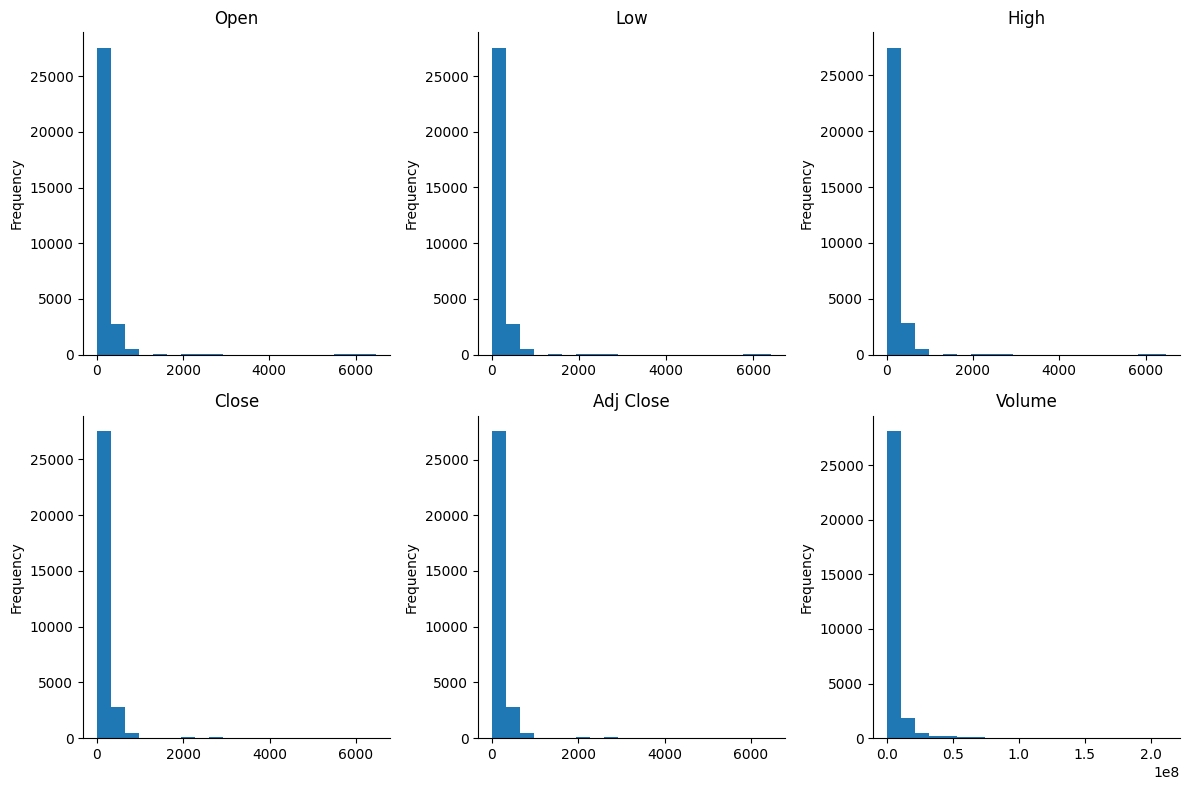

In [ ]:
# visualize the distribution of variables
import matplotlib.pyplot as plt

df_cols = ["Open", "Low", "High", "Close", "Adj Close", "Volume"]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

for i, col in enumerate(df_cols):
    ax = axes[i // 3, i % 3]
    df[col].plot(kind="hist", bins=20, ax=ax, title=col)
    ax.spines[["top", "right"]].set_visible(False)

plt.tight_layout()
plt.show()

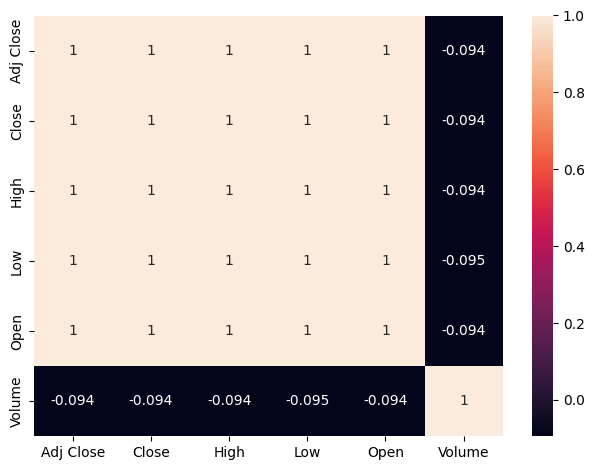

In [ ]:
# let's see a correlation matrix heatmap
import seaborn as sns

corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True)
plt.tight_layout()
plt.show()

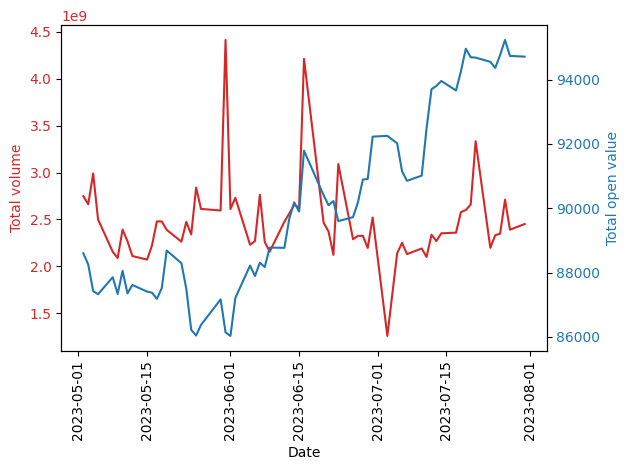

In [ ]:
# plot the total volume and open value against time
dates = df["Date"].unique()
daily_data = df.groupby("Date")
daily_volume = daily_data["Volume"].sum()
daily_open_value = daily_data["Open"].sum()

fig, ax1 = plt.subplots()

color = "tab:red"
ax1.set_xlabel("Date")
ax1.set_ylabel("Total volume", color=color)
ax1.plot(dates, daily_volume, color=color)
ax1.tick_params(axis="y", labelcolor=color)
ax1.tick_params(axis='x', labelrotation=90)

ax2 = ax1.twinx()

color = "tab:blue"
ax2.set_ylabel("Total open value", color=color)
ax2.plot(dates, daily_open_value, color=color)
ax2.tick_params(axis="y", labelcolor=color)

fig.tight_layout()
plt.show()

In [ ]:
# calculate the growth rate
dates = df["Date"].unique()
daily_data = df.groupby("Date")
daily_adj_close_value = daily_data["Adj Close"].sum()

adj_close_df = pd.DataFrame(daily_adj_close_value)
adj_close_df["Growth_rate"] = adj_close_df[["Adj Close"]].pct_change()*100

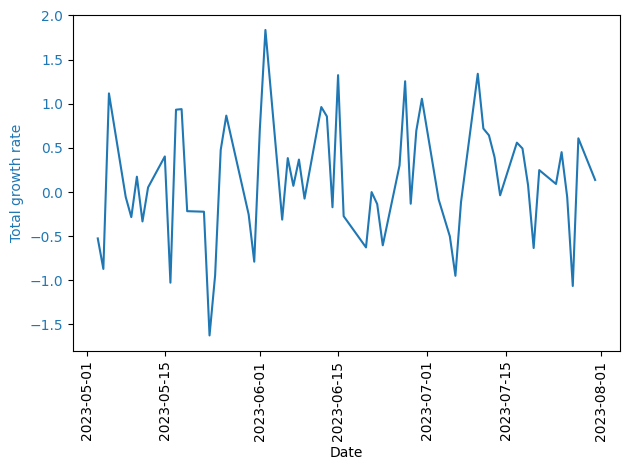

In [ ]:
# plot the growth rate
fig, ax1 = plt.subplots()

color = "tab:blue"
ax1.set_xlabel("Date")
ax1.set_ylabel("Total growth rate", color=color)
ax1.plot(dates, adj_close_df["Growth_rate"], color=color)
ax1.tick_params(axis="y", labelcolor=color)
ax1.tick_params(axis='x', labelrotation=90)

fig.tight_layout()
plt.show()

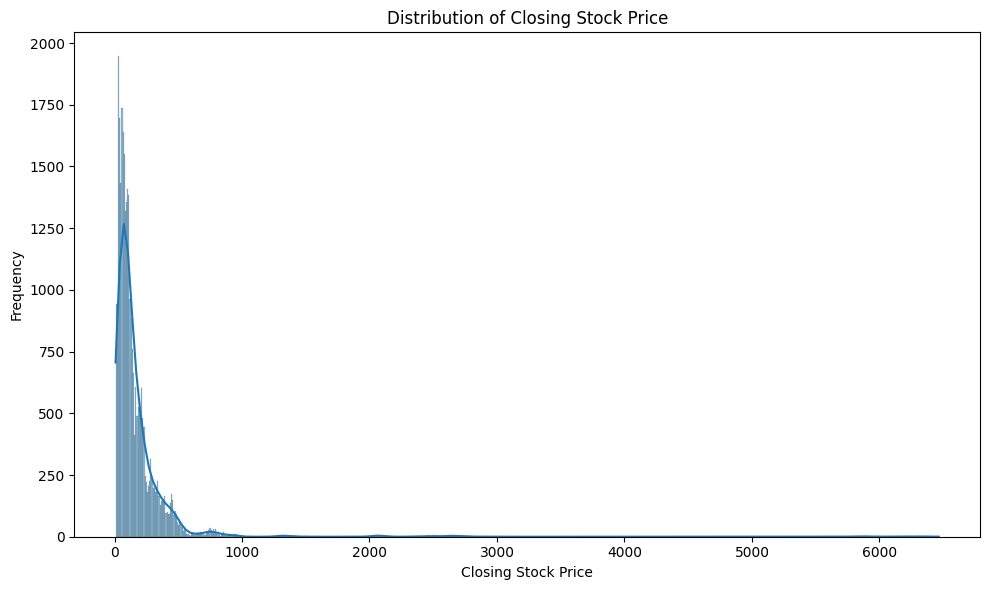

In [ ]:
# plot distribution of closing stock price
plt.figure(figsize=(10, 6))
sns.histplot(df["Adj Close"], kde=True)
plt.title("Distribution of Closing Stock Price")
plt.xlabel("Closing Stock Price")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Part 4: Community Detection clustering

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# load the dataset from the drive
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/HWSWmoduleA/sp500_stocks_62days.csv", index_col=0)
df["Date"] = pd.to_datetime(df["Date"], format="%Y/%m/%d")
df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
0,2023-05-02,MMM,102.98000,102.98,105.70,102.66,105.51,3012000.0
1,2023-05-03,MMM,102.83000,102.83,104.60,102.67,103.50,2056100.0
2,2023-05-04,MMM,101.84000,101.84,102.98,100.76,102.55,2963200.0
3,2023-05-05,MMM,103.35000,103.35,103.48,102.05,102.80,1943100.0
4,2023-05-08,MMM,102.34000,102.34,103.93,101.65,103.56,2094000.0
...,...,...,...,...,...,...,...,...
31181,2023-07-25,ZTS,189.26654,190.15,193.28,184.34,184.50,3952800.0
31182,2023-07-26,ZTS,191.10796,192.00,192.89,188.17,189.39,2922500.0
31183,2023-07-27,ZTS,187.81332,188.69,194.99,188.48,192.80,2173400.0
31184,2023-07-28,ZTS,189.01770,189.90,191.28,187.86,190.50,1899800.0


In [ ]:
# make a dictionary with the stock symbol as key and corresponding time series as value
stock_dict = {}
for symbol in df["Symbol"].unique():
  stock_df = df.loc[df["Symbol"] == symbol]
  stock_dict[symbol] = stock_df

In [ ]:
# function to generate the cross correlation matrix
import math
def get_pearson_coeff(stock1, stock2, column):
  avg1 = stock1[[column]].mean().values[0]
  avg2 = stock2[[column]].mean().values[0]
  numerator = 0
  denominator1 = 0
  denominator2 = 0
  for i in range(len(stock1)):
    numerator += (stock1[column].iloc[i] - avg1)*(stock2[column].iloc[i] - avg2)
    denominator1 += (stock1[column].iloc[i] - avg1)**2
    denominator2 += (stock2[column].iloc[i] - avg2)**2

  return numerator/math.sqrt(denominator1*denominator2)

In [ ]:
# make the cross correlation matrix
columns = list(stock_dict.keys())
dataset = []
for stock1 in columns:
  row = []
  for stock2 in columns:
    row.append(get_pearson_coeff(stock_dict[stock1], stock_dict[stock2], "Adj Close"))
  dataset.append(row)

cross_corr_matrix = pd.DataFrame(dataset, columns, columns)

In [ ]:
# save the matrix for later use
cross_corr_matrix.to_csv("/content/drive/MyDrive/HWSWmoduleA/sp500_stocks_62days_cross_corr.csv")

In [ ]:
# load the matrix if you don't have it in memory
cross_corr_matrix = pd.read_csv("/content/drive/MyDrive/HWSWmoduleA/sp500_stocks_62days_cross_corr.csv", index_col=0)

In [ ]:
# let's take a peek at the cross correlation matrix
cross_corr_matrix

,MMM,AOS,ABT,ABBV,ACN,ADBE,AMD,AES,AFL,A,...,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
MMM,1.000000,0.606726,0.596777,0.527495,0.276243,0.398541,-0.105007,0.560766,0.701678,0.405469,...,-0.096394,0.296537,0.581486,0.063823,0.586582,0.520911,0.481796,0.401950,0.581287,0.654115
AOS,0.606726,1.000000,0.511341,-0.002029,0.505706,0.720898,0.056813,0.494367,0.901640,0.049813,...,0.414534,0.811100,0.498543,-0.215280,0.794470,0.425945,0.866469,0.723799,0.610230,0.280577
ABT,0.596777,0.511341,1.000000,0.661504,-0.248528,0.025558,-0.677162,0.775966,0.425377,0.730267,...,0.213066,0.241405,0.714942,0.462662,0.354715,0.662196,0.294468,0.493251,0.107888,0.858482
ABBV,0.527495,-0.002029,0.661504,1.000000,-0.505428,-0.416701,-0.658047,0.641973,0.041680,0.858748,...,-0.389678,-0.389860,0.562526,0.716993,-0.146845,0.405129,-0.140644,-0.103132,-0.016668,0.803387
ACN,0.276243,0.505706,-0.248528,-0.505428,1.000000,0.909772,0.810656,-0.286594,0.641939,-0.624848,...,0.091274,0.627671,-0.270575,-0.802603,0.582942,-0.092536,0.642616,0.295257,0.768128,-0.341266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YUM,0.520911,0.425945,0.662196,0.405129,-0.092536,0.079004,-0.422886,0.650328,0.428364,0.492998,...,0.398945,0.328650,0.644263,0.289180,0.510587,1.000000,0.224794,0.651560,-0.060652,0.584487
ZBRA,0.481796,0.866469,0.294468,-0.140644,0.642616,0.773498,0.291203,0.309016,0.852654,-0.139335,...,0.282021,0.788840,0.322593,-0.356972,0.691370,0.224794,1.000000,0.543494,0.699415,0.159373
ZBH,0.401950,0.723799,0.493251,-0.103132,0.295257,0.563174,-0.125229,0.469763,0.665035,0.013273,...,0.671498,0.831289,0.474125,-0.187316,0.838348,0.651560,0.543494,1.000000,0.149126,0.156877
ZION,0.581287,0.610230,0.107888,-0.016668,0.768128,0.763655,0.532874,-0.027957,0.755739,-0.222174,...,-0.164441,0.465091,0.015699,-0.498264,0.514972,-0.060652,0.699415,0.149126,1.000000,0.107796


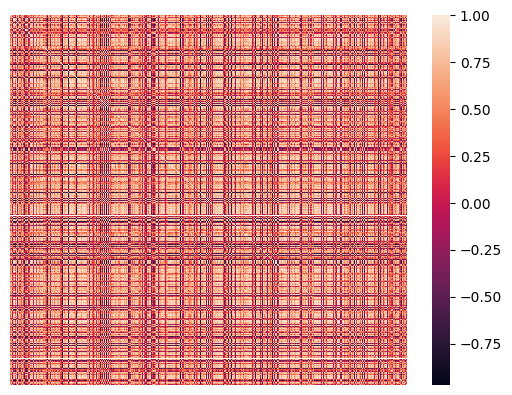

<Figure size 2000x2000 with 0 Axes>

In [ ]:
# visualize the correlation matrix through a heatmap
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cross_corr_matrix, xticklabels=False, yticklabels=False)
plt.figure(figsize=(20, 20))
plt.tight_layout()
plt.show()

In [ ]:
# in this cell we define some useful functions

# scaler of datasets, needed for visualization of multiple stocks
def min_max_scaler(dataframe):
  data = dataframe.copy()
  columns = ["Adj Close", "Close", "High", "Low", "Open", "Volume"]
  data[columns] = (data[columns] - data[columns].min(axis=0)) / (data[columns].max(axis=0) - data[columns].min(axis=0))
  return data

# this function plots multiple stocks together, normalized cause we are interested in trend similarities
def plot_multiple_stocks(df, stock_dict, stock_names, variable="Adj Close"):

    stock_dict = stock_dict.copy()
    for stock in list(stock_dict.keys()):
      stock_dict[stock] = min_max_scaler(stock_dict[stock].copy())

    dates = df["Date"].unique()
    fig, ax = plt.subplots()

    colors = plt.cm.tab10(range(len(stock_names)))

    for i, name in enumerate(stock_names):

        stock_data = stock_dict[name][variable]
        color = colors[i % len(colors)]
        ax.plot(dates, stock_data, label=name, color=color)

    ax.set_xlabel("Date")
    ax.set_ylabel(variable)
    ax.tick_params(axis="x", labelrotation=90)
    plt.legend()

    plt.tight_layout()
    plt.show()

# this function plots two stocks together with different scales to have a greater detail on their trend
def plot_two_stocks(cross_corr_matrix, df, stock_dict, name1, name2, variable="Adj Close"):

    correlation = cross_corr_matrix.loc[name1][name2]
    dates = df["Date"].unique()
    stock1 = stock_dict[name1][variable]
    stock2 = stock_dict[name2][variable]

    fig, ax1 = plt.subplots()

    color = "tab:green"
    ax1.set_xlabel("Date")
    ax1.set_ylabel(name1, color=color)
    ax1.plot(dates, stock1, color=color)
    ax1.tick_params(axis="y", labelcolor=color)
    ax1.tick_params(axis="x", labelrotation=90)

    ax2 = ax1.twinx()

    color = "tab:orange"
    ax2.set_ylabel(name2, color=color)
    ax2.plot(dates, stock2, color=color)
    ax2.tick_params(axis="y", labelcolor=color)

    plt.title(f"Cross Correlation = {correlation}")
    fig.tight_layout()
    plt.show()

# utility function for community visualization
def from_indices_to_names(index_list, columns):

  names_list = []
  for index in index_list:
    stock_name = columns[index]
    names_list.append(stock_name)
  return names_list

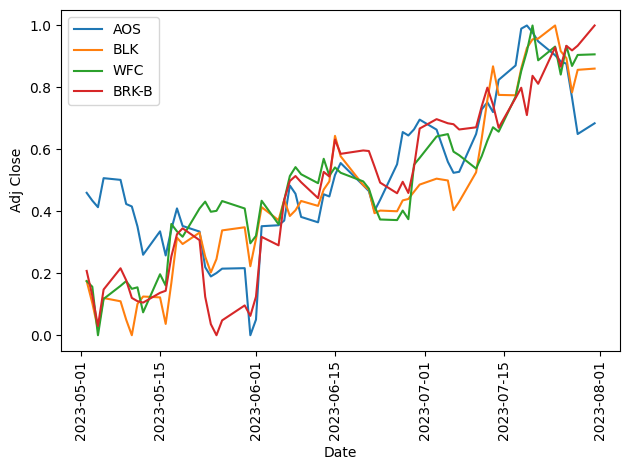

In [ ]:
# let's visualize the trends of multiple stocks at the time (normalized for visualization purposes)
plot_multiple_stocks(df, stock_dict, ["AOS", "BLK", "WFC", "BRK-B"])

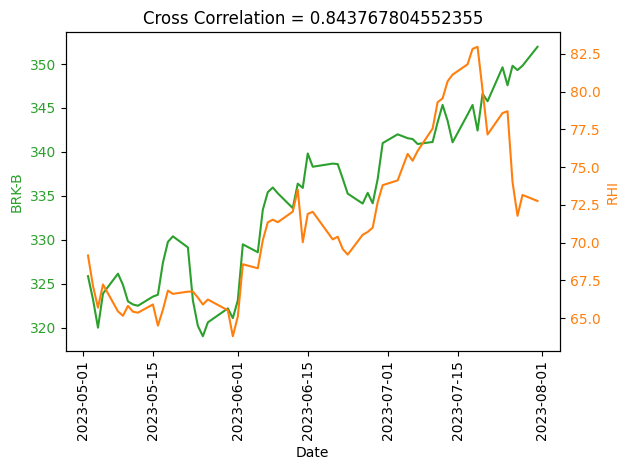

In [ ]:
# we can also get a better look at two stocks to see actual stock value as y axis
import random
name1, name2 = random.choices(list(stock_dict.keys()), k=2)
plot_two_stocks(cross_corr_matrix, df, stock_dict, name1, name2)

In [ ]:
# this function creates a weighted or unweighted graph object from a correlation matrix
# an edge is created if the correlation between the two nodes (i.e. stocks) is greater than threshold
# the weight of the edge is equal to the absolute  value of the cross correlation
import networkx as nx
def create_graph(matrix, threshold=0.5, weighted=True, remove_isolated=True):
  cross_corr_matrix = matrix.where(matrix != 1.0, 0)  # avoid self loops
  if weighted:
    adj_matrix = cross_corr_matrix.abs().where(cross_corr_matrix >= threshold, 0)
    G = nx.from_numpy_array(adj_matrix.values, edge_attr="weight")
  else:
    adj_matrix = (cross_corr_matrix.abs() > threshold).astype(int)
    G = nx.from_numpy_array(adj_matrix.values)
  isolated_nodes = list(nx.isolates(G))
  if remove_isolated: G.remove_nodes_from(isolated_nodes)
  return G, isolated_nodes

In [ ]:
# for visualization purposes
! pip install mpld3

In [ ]:
# let's try to visualize the graph
import mpld3
from mpld3 import plugins

G, isolated = create_graph(cross_corr_matrix, weighted=True, threshold=0.97)
pos=nx.spring_layout(G, k=0.1)
nx.draw(G, pos, node_color="red", edge_color="blue", node_size=1, width=0.2)
mpld3.display()

In [ ]:
!pip install cdlib

The methods used for the analysis are:
- Louvain
- Label Propagation
- Infomap
- Walktrap
- AGDL

In [ ]:
from cdlib.evaluation import fraction_over_median_degree
from cdlib.evaluation import conductance
from cdlib.evaluation import normalized_cut
from cdlib.evaluation import cut_ratio

In [ ]:
# this function will run statistics on given communities
def extract_statistics(graph, coms):

  fmd = fraction_over_median_degree(G, coms, summary=False)
  conduct = conductance(G, coms, summary=False)
  cut = cut_ratio(G, coms, summary=False)
  norm_cut = normalized_cut(G, coms, summary=False)

  index = ["Fraction over median degree", "Conductance", "Cut ratio", "Normalized cut ratio"]
  columns = ["Cluster " + str(i) for i in range(1, len(coms.communities) + 1)]
  data = [fmd, conduct, cut, norm_cut]

  return pd.DataFrame(data, index, columns)


### Louvain algorithm

#### Unweighted graph

In [ ]:
# louvain method for unweighted graph
from cdlib import algorithms, viz
import networkx as nx

resolution = 1.
threshold = 0.97
G, isolated = create_graph(cross_corr_matrix, weighted=False, threshold=threshold)
coms = algorithms.louvain(G, resolution=resolution)
print("Number of isolated nodes =", len(isolated))

Number of isolated nodes = 390


In [ ]:
extract_statistics(G, coms)

,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,Cluster 9,Cluster 10,...,Cluster 15,Cluster 16,Cluster 17,Cluster 18,Cluster 19,Cluster 20,Cluster 21,Cluster 22,Cluster 23,Cluster 24
Fraction over median degree,0.368421,0.473684,0.333333,0.400000,0.444444,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Conductance,0.145161,0.152174,0.206897,0.225806,0.076923,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Cut ratio,0.010078,0.007839,0.007018,0.006796,0.002137,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Normalized cut ratio,0.208991,0.197926,0.242611,0.245636,0.082670,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
pos = nx.spring_layout(G, k=0.1)
viz.plot_network_clusters(G, coms, pos, node_size=10)
mpld3.display()

#### Weighted graph

In [ ]:
# louvain method for weighted graph
from cdlib import algorithms, viz
import networkx as nx

resolution = 1.
threshold = 0.97
G, isolated = create_graph(cross_corr_matrix, weighted=True, threshold=threshold)
coms = algorithms.louvain(G, resolution=resolution)
print("Number of isolated nodes =", len(isolated))

Number of isolated nodes = 391


In [ ]:
extract_statistics(G, coms)

,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,Cluster 9,Cluster 10,...,Cluster 14,Cluster 15,Cluster 16,Cluster 17,Cluster 18,Cluster 19,Cluster 20,Cluster 21,Cluster 22,Cluster 23
Fraction over median degree,0.409091,0.470588,0.466667,0.307692,0.444444,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Conductance,0.159664,0.211268,0.173333,0.219512,0.076923,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Cut ratio,0.009596,0.009288,0.008935,0.006993,0.002157,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Normalized cut ratio,0.225866,0.257139,0.214086,0.245599,0.082703,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
pos = nx.spring_layout(G, k=0.1)
viz.plot_network_clusters(G, coms, pos, node_size=10)
mpld3.display()

### Label Propagation algorithm

#### Unweighted graph

In [ ]:
# Label Propagation method for unweighted graph
from cdlib import algorithms, viz
import networkx as nx

resolution = 1.
threshold = 0.97
G, isolated = create_graph(cross_corr_matrix, weighted=False, threshold=threshold)
coms = algorithms.label_propagation(G)
print("Number of isolated nodes =", len(isolated))

Number of isolated nodes = 390


In [ ]:
extract_statistics(G, coms)

,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,Cluster 9,Cluster 10,...,Cluster 22,Cluster 23,Cluster 24,Cluster 25,Cluster 26,Cluster 27,Cluster 28,Cluster 29,Cluster 30,Cluster 31
Fraction over median degree,0.433333,0.384615,0.375000,0.500000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
Conductance,0.058824,0.232877,0.285714,0.230769,0.333333,0.400000,0.142857,0.333333,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.333333,0.333333,0.0
Cut ratio,0.004016,0.013077,0.009524,0.006881,0.009091,0.012121,0.003030,0.009091,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.004505,0.004505,0.004505,0.0
Normalized cut ratio,0.104278,0.284236,0.308061,0.239034,0.341508,0.410870,0.145597,0.341508,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.336043,0.336043,0.336043,0.0


In [ ]:
pos = nx.spring_layout(G, k=0.1)
viz.plot_network_clusters(G, coms, pos, node_size=10)
mpld3.display()

### Infomap algorithm

#### Unweighted graph

In [ ]:
# louvain method for unweighted graph
from cdlib import algorithms, viz
import networkx as nx

resolution = 1.2
threshold = 0.97
G, isolated = create_graph(cross_corr_matrix, weighted=False, threshold=threshold)
coms = algorithms.infomap(G)
print("Number of isolated nodes =", len(isolated))

Number of isolated nodes = 390


In [ ]:
extract_statistics(G, coms)

,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,Cluster 9,Cluster 10,...,Cluster 21,Cluster 22,Cluster 23,Cluster 24,Cluster 25,Cluster 26,Cluster 27,Cluster 28,Cluster 29,Cluster 30
Fraction over median degree,0.500000,0.500000,0.300000,0.285714,0.500000,0.400000,0.500000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
Conductance,0.107914,0.193548,0.302326,0.448276,0.157895,0.200000,0.250000,0.142857,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.333333,0.333333,0.0
Cut ratio,0.007493,0.009901,0.012621,0.017520,0.004673,0.005556,0.004587,0.003030,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.004505,0.004505,0.004505,0.0
Normalized cut ratio,0.165385,0.229693,0.339153,0.483698,0.166298,0.208310,0.255464,0.145597,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.336043,0.336043,0.336043,0.0


In [ ]:
pos = nx.spring_layout(G, k=0.1)
viz.plot_network_clusters(G, coms, pos, node_size=10)
mpld3.display()

#### Weighted graph

In [ ]:
# louvain method for weighted graph
from cdlib import algorithms, viz
import networkx as nx

resolution = 1.2
threshold = 0.97
G, isolated = create_graph(cross_corr_matrix, weighted=True, threshold=threshold)
coms = algorithms.infomap(G)
print("Number of isolated nodes =", len(isolated))

Number of isolated nodes = 391


In [ ]:
extract_statistics(G, coms)

,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,Cluster 9,Cluster 10,...,Cluster 20,Cluster 21,Cluster 22,Cluster 23,Cluster 24,Cluster 25,Cluster 26,Cluster 27,Cluster 28,Cluster 29
Fraction over median degree,0.464286,0.500000,0.300000,0.500000,0.400000,0.500000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
Conductance,0.060241,0.193548,0.302326,0.157895,0.200000,0.250000,0.142857,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.333333,0.333333,0.0
Cut ratio,0.004252,0.010000,0.012745,0.004717,0.005607,0.004630,0.003058,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.004545,0.004545,0.004545,0.0
Normalized cut ratio,0.105286,0.229912,0.339363,0.166345,0.208357,0.255495,0.145612,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.336058,0.336058,0.336058,0.0


In [ ]:
pos = nx.spring_layout(G, k=0.1)
viz.plot_network_clusters(G, coms, pos, node_size=10)
mpld3.display()

### AGDL algorithm

#### Unweighted graph

In [ ]:
# louvain method for unweighted graph
from cdlib import algorithms, viz
import networkx as nx

resolution = 1.2
threshold = 0.97
G, isolated = create_graph(cross_corr_matrix, weighted=False, threshold=threshold)
coms = algorithms.agdl(G, number_communities=6, kc=1)
print("Number of isolated nodes =", len(isolated))

Number of isolated nodes = 390


In [ ]:
extract_statistics(G, coms)

,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,Cluster 9,Cluster 10,...,Cluster 13,Cluster 14,Cluster 15,Cluster 16,Cluster 17,Cluster 18,Cluster 19,Cluster 20,Cluster 21,Cluster 22
Fraction over median degree,0.370370,0.391304,0.388889,0.444444,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Conductance,0.090909,0.190840,0.253731,0.076923,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Cut ratio,0.004307,0.012077,0.009942,0.002137,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Normalized cut ratio,0.126623,0.277345,0.304176,0.082670,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
pos = nx.spring_layout(G, k=0.1)
viz.plot_network_clusters(G, coms, pos, node_size=10)
mpld3.display()

#### Weighted graph

In [ ]:
# louvain method for weighted graph
from cdlib import algorithms, viz
import networkx as nx

resolution = 1.2
threshold = 0.97
G, isolated = create_graph(cross_corr_matrix, weighted=True, threshold=threshold)
coms = algorithms.agdl(G, number_communities=6, kc=1)
print("Number of isolated nodes =", len(isolated))

Number of isolated nodes = 391


In [ ]:
extract_statistics(G, coms)

,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,Cluster 9,Cluster 10,...,Cluster 14,Cluster 15,Cluster 16,Cluster 17,Cluster 18,Cluster 19,Cluster 20,Cluster 21,Cluster 22,Cluster 23
Fraction over median degree,0.448276,0.333333,0.300000,0.400000,0.333333,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Conductance,0.084967,0.159420,0.346939,0.225806,0.266667,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Cut ratio,0.005401,0.006501,0.016667,0.006863,0.008630,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Normalized cut ratio,0.138909,0.193688,0.395097,0.245749,0.289266,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
pos = nx.spring_layout(G, k=0.1)
viz.plot_network_clusters(G, coms, pos, node_size=10)
mpld3.display()

### Visualization of some of the stocks in the same community (Louvain algorithm)

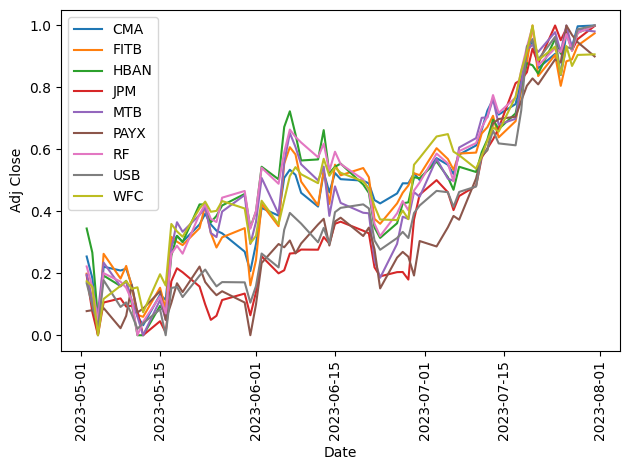

In [ ]:
stocks = from_indices_to_names(coms.communities[4], list(stock_dict.keys()))
plot_multiple_stocks(df, stock_dict, stocks)

In [ ]:
coms.communities[7]

[26, 183]

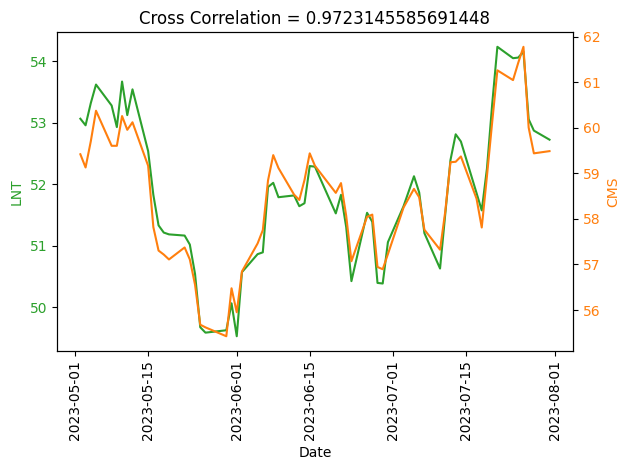

In [ ]:
# visualize one of the pairs

stock1, stock2 = from_indices_to_names(coms.communities[5], list(stock_dict.keys()))
plot_two_stocks(cross_corr_matrix, df, stock_dict, stock1, stock2)